# Time series clustering exercise

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import zipfile
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
import seaborn

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

## Downloading census and zip code data, and moving to PUIData

In [2]:
#these commands can be run on the shell and get the data with the command wget
#the cell needs to be run only once
#!for ((y=94; y<=99; y+=1)); do wget \
#https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp$y\totals.zip; done

#!for ((y=0; y<=1; y+=1)); do wget \
#https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0$y\totals.zip; done

#!for ((y=2; y<=9; y+=1)); do wget \
#https://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

#!for ((y=10; y<=14; y+=1)); do wget \
#https://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

#!wget "https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip"
#!unzip nyct2010_17c.zip -d Census

#!mv *.zip $PUIDATA

## Data cleaning and prepping the dataframe

In [3]:
zipDF = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/ZipCode/ZIP_CODE_040114.shp")
zipDF = zipDF[['ZIPCODE', 'geometry']].rename(columns={'ZIPCODE':'zip'})
zipDF['zip'] = zipDF['zip'].astype(int)
zipDF.head(3)

,zip,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."


In [4]:
yrRange = map(str, list(range(1994,2015)))
yrRange2 = []

for yr in yrRange:
    twoDigits = yr[-2:]
    yrRange2.append(twoDigits)
    fname = "zbp" + twoDigits + "totals.zip"
    zf = zipfile.ZipFile(os.getenv("PUIDATA") + "/" + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df.columns = map(str.lower, df.columns)
    df = df[['zip','est']]

    #merging annual time series to zipDF
    zipDF = pd.merge(zipDF, df, how = 'inner', on='zip').rename(columns={'est':twoDigits})

timeVals = zipDF[yrRange2]
zipDF = zipDF[['zip','geometry']]

In [5]:
timeVals['avg'] = timeVals.mean(axis=1)
timeVals['std'] = timeVals.std(axis=1)

In [6]:
timeVals.head()

,94,95,96,97,98,99,00,01,02,03,...,07,08,09,10,11,12,13,14,avg,std
0,51,50,53,51,51,58,65,57,78,74,...,84,90,92,98,101,95,99,109,76.285714,19.039165
1,406,420,433,456,476,473,477,493,546,569,...,556,592,621,675,674,726,755,772,562.428571,106.472698
2,505,494,502,527,519,541,520,527,577,581,...,587,602,647,699,713,721,731,752,594.666667,81.176077
3,381,387,388,410,416,409,417,422,479,488,...,514,520,543,580,597,623,673,696,496.428571,92.085660
4,985,1015,1049,1075,1118,1149,1161,1180,1228,1247,...,1377,1397,1457,1474,1523,1605,1687,1736,1305.761905,212.234126


In [7]:
#normalizing time series values
stdVals = timeVals.loc[:,"94":"14"].sub(timeVals["avg"], 
                                        axis=0).div(timeVals["std"], axis=0)
stdVals.head()

,94,95,96,97,98,99,00,01,02,03,...,05,06,07,08,09,10,11,12,13,14
0,-1.328089,-1.380613,-1.223043,-1.328089,-1.328089,-0.960426,-0.592763,-1.012950,0.090040,-0.120053,...,0.300133,0.195087,0.405180,0.720320,0.825366,1.140506,1.298076,0.982936,1.193030,1.718263
1,-1.469190,-1.337700,-1.215603,-0.999586,-0.811744,-0.839920,-0.802352,-0.652079,-0.154298,0.061719,...,-0.060378,0.024151,-0.060378,0.277737,0.550107,1.057280,1.047888,1.536276,1.808646,1.968311
2,-1.104595,-1.240103,-1.141551,-0.833579,-0.932130,-0.661114,-0.919811,-0.833579,-0.217634,-0.168358,...,-0.094445,-0.303866,-0.094445,0.090339,0.644689,1.285272,1.457737,1.556288,1.679477,1.938174
3,-1.253491,-1.188335,-1.177475,-0.938567,-0.873410,-0.949427,-0.862551,-0.808254,-0.189265,-0.091530,...,-0.058951,0.027924,0.190816,0.255973,0.505740,0.907540,1.092151,1.374497,1.917469,2.167237
4,-1.511359,-1.370005,-1.209805,-1.087299,-0.884692,-0.738627,-0.682086,-0.592562,-0.366397,-0.276873,...,0.123628,0.118916,0.335658,0.429894,0.712600,0.792700,1.023578,1.409943,1.796309,2.027186


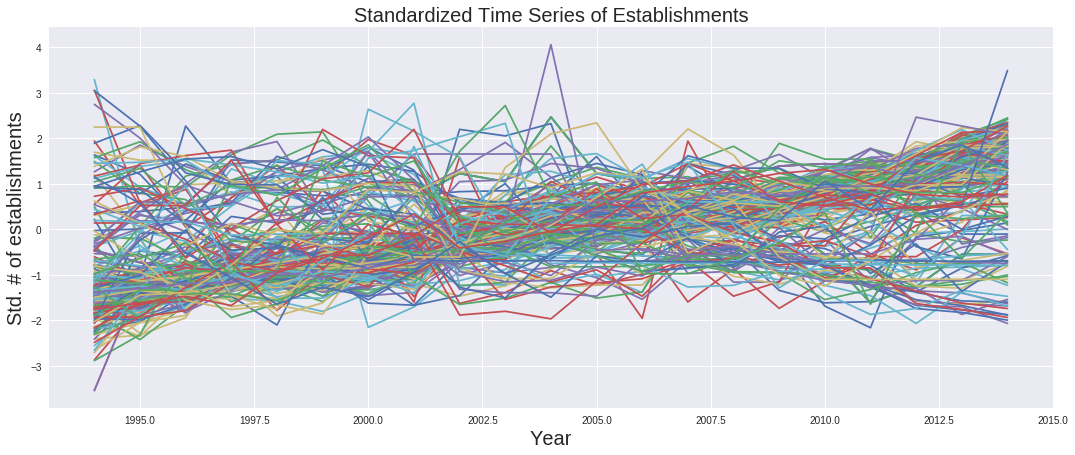

In [8]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(111)

for i in range(0,len(stdVals)): 
    pl.plot(yrRange, stdVals.iloc[i])
pl.xlabel("Year", fontsize=20)
pl.ylabel("Std. # of establishments", fontsize=20)
pl.title("Standardized Time Series of Establishments", fontsize=20);

#### Figure 1. This figure shows the standardized time series of number of business establishents in different NYC zip codes from 1994 to 2014.

## K-means clustering

In [9]:
nc = 6

km = KMeans(n_clusters=nc)
km.fit(stdVals)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

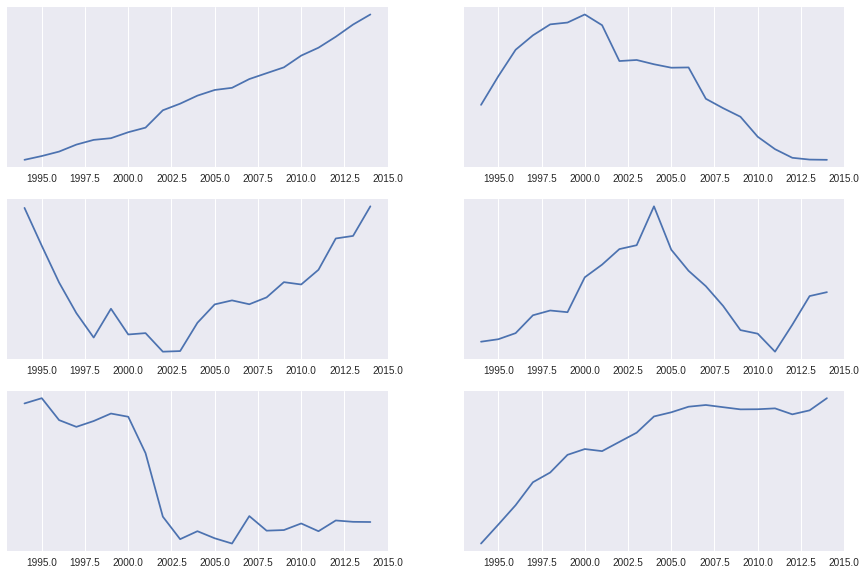

In [10]:
fig = pl.figure(figsize=(15,10))
for i,cc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(yrRange, cc)
    ax.set_yticks([])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(10) 
        #tick.label.set_rotation('vertical')

#### Figure 2. This figure shows the time series for the 6 cluster centers determined by the K-means clusters.

In [11]:
for lab in set(km.labels_):
    print ('there are ', sum(km.labels_==lab), "time series in cluster", lab)

('there are ', 152, 'time series in cluster', 0)
('there are ', 19, 'time series in cluster', 1)
('there are ', 13, 'time series in cluster', 2)
('there are ', 14, 'time series in cluster', 3)
('there are ', 16, 'time series in cluster', 4)
('there are ', 29, 'time series in cluster', 5)


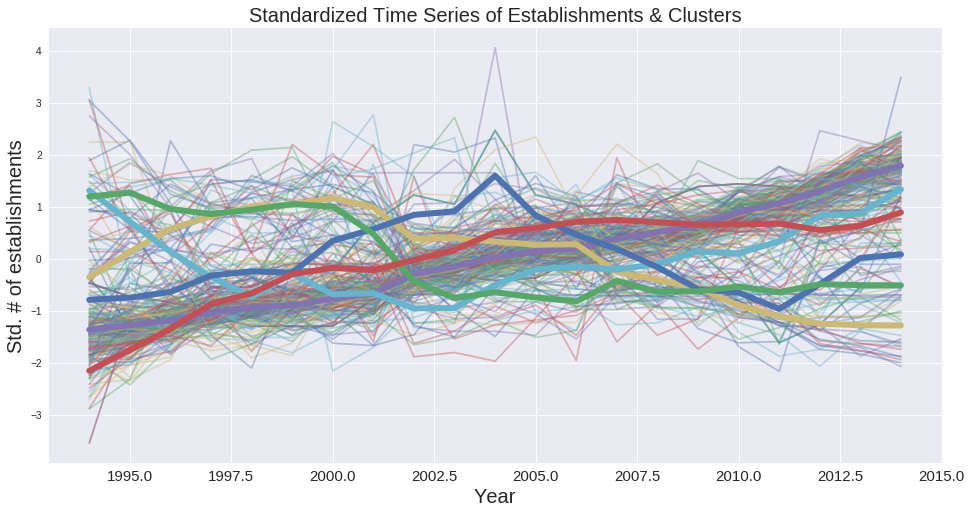

In [12]:
fig = pl.figure(figsize=(16,8))
ax = fig.add_subplot(111)

for i in range(0,len(stdVals)): 
    ax.plot(yrRange, stdVals.iloc[i], alpha=0.4)
    
for i,cc in enumerate(km.cluster_centers_):
    ax.plot(yrRange, cc, linewidth=6)
    #ax.set_yticks([])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15) 
        
pl.xlabel("Year", fontsize=20)
pl.ylabel("Std. # of establishments", fontsize=20)
pl.title("Standardized Time Series of Establishments & Clusters", fontsize=20);

#### Figure 3. This figure shows the standardized time series of number of business establishents in different NYC zip codes from 1994 to 2014. The bolded lines show the 6 cluster centers as determined by the K-means clusters.

## Gaussian mixture model (GMM) clustering

In [13]:
GMcluster = GMM(n_components = 6, random_state = 100)
GMlabels = GMcluster.fit_predict(stdVals)
for lab in set(GMlabels):
    print ('there are ', sum(GMlabels==lab), "time series in cluster", lab)

('there are ', 109, 'time series in cluster', 0)
('there are ', 21, 'time series in cluster', 1)
('there are ', 13, 'time series in cluster', 2)
('there are ', 44, 'time series in cluster', 3)
('there are ', 34, 'time series in cluster', 4)
('there are ', 22, 'time series in cluster', 5)


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/opt/rh/anacond

## NYC overlay of clusters

In [14]:
zipDFfin = zipDF.join(stdVals)
zipDFfin['GMClusters'] = GMlabels.astype(str)
zipDFfin['KmeanClusters'] = km.labels_.astype(str)

In [15]:
zipDFfin.head()

,zip,geometry,94,95,96,97,98,99,00,01,...,07,08,09,10,11,12,13,14,GMClusters,KmeanClusters
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",-1.328089,-1.380613,-1.223043,-1.328089,-1.328089,-0.960426,-0.592763,-1.012950,...,0.405180,0.720320,0.825366,1.140506,1.298076,0.982936,1.193030,1.718263,0,0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",-1.469190,-1.337700,-1.215603,-0.999586,-0.811744,-0.839920,-0.802352,-0.652079,...,-0.060378,0.277737,0.550107,1.057280,1.047888,1.536276,1.808646,1.968311,0,0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",-1.104595,-1.240103,-1.141551,-0.833579,-0.932130,-0.661114,-0.919811,-0.833579,...,-0.094445,0.090339,0.644689,1.285272,1.457737,1.556288,1.679477,1.938174,0,0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",-1.253491,-1.188335,-1.177475,-0.938567,-0.873410,-0.949427,-0.862551,-0.808254,...,0.190816,0.255973,0.505740,0.907540,1.092151,1.374497,1.917469,2.167237,0,0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",-1.511359,-1.370005,-1.209805,-1.087299,-0.884692,-0.738627,-0.682086,-0.592562,...,0.335658,0.429894,0.712600,0.792700,1.023578,1.409943,1.796309,2.027186,0,0


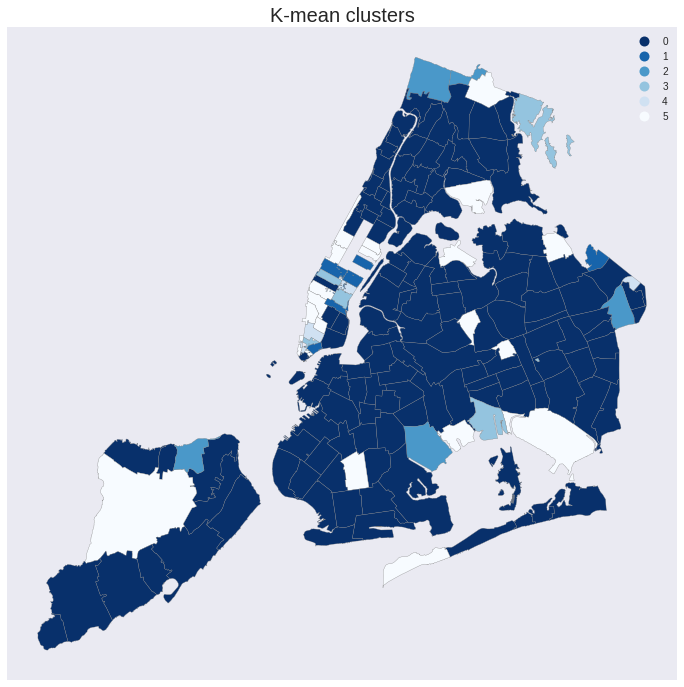

In [16]:
fig = pl.figure(figsize=(12,12))
ax = fig.add_subplot(111)

zipDFfin.plot(column='KmeanClusters',ax=ax, legend=True,cmap='Blues_r',edgecolor='grey')
pl.title('K-mean clusters', fontsize=20);
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

#### Figure 4. This figure shows a cloropleth for 6 k-means clusters of business patterns (number of businesses) over time at the zipcode level for NYC zipcodes: each color indicates a cluster.

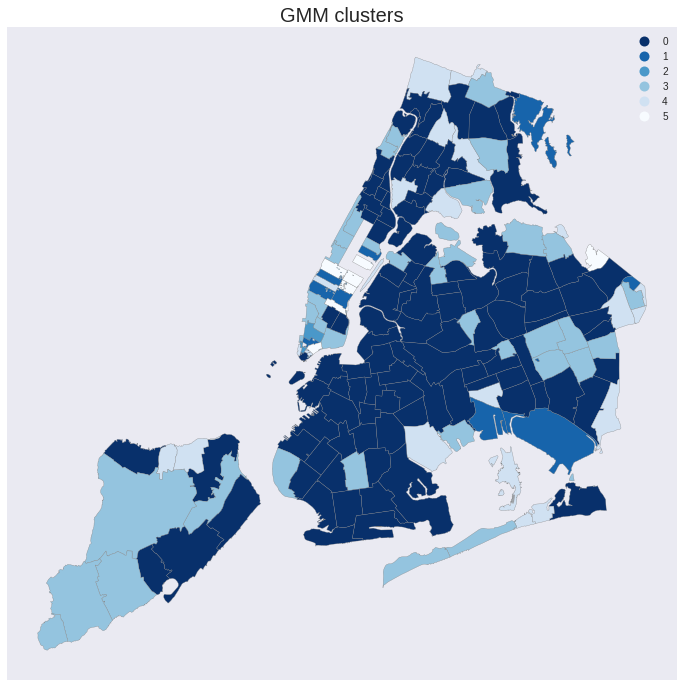

In [17]:
fig = pl.figure(figsize=(12,12))
ax = fig.add_subplot(111)

zipDFfin.plot(column='GMClusters',ax=ax, legend=True,cmap='Blues_r',edgecolor='grey')
pl.title('GMM clusters', fontsize=20);
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

#### Figure 5. This figure shows a choropleth for 6 GMM clusters of business patterns (number of businesses) over time at the zipcode level for NYC zipcodes: each color indicates a cluster.

## Comparing the algorithms & interpreting the results

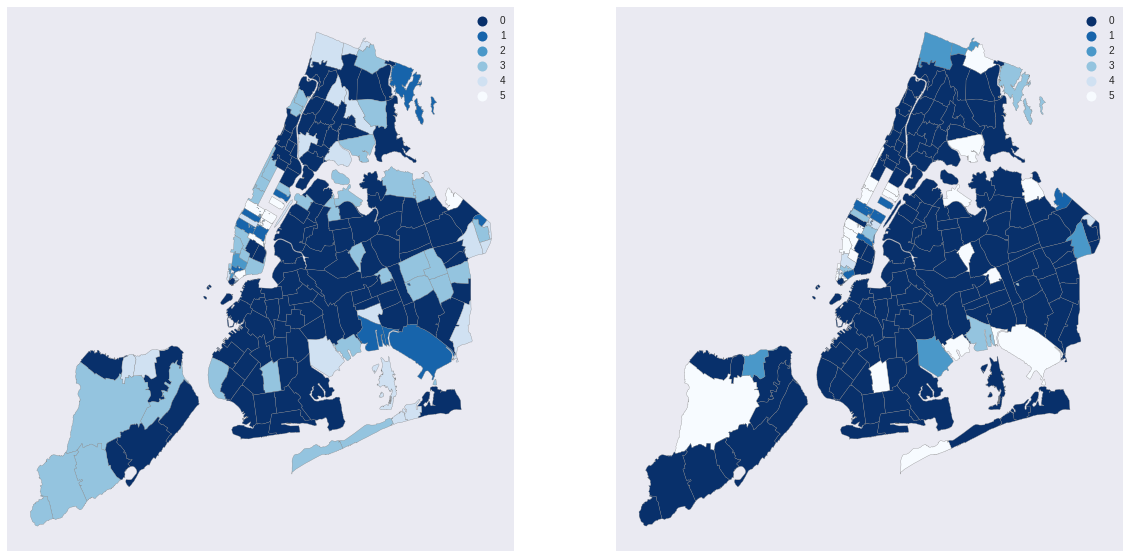

In [18]:
fig = pl.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

zipDFfin.plot(column='GMClusters',ax=ax1, legend=True,cmap='Blues_r',edgecolor='grey')
zipDFfin.plot(column='KmeanClusters',ax=ax2, legend=True,cmap='Blues_r',edgecolor='grey')

ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

#### Figure 6. This figure shows a side-by-side comparison of the choropleths for the two clustering algorithms.

The two algorithms seemed to delivered pretty similar results overall, the majority of the cluster groups had pretty similar zip codes within them, with a few differences mainly in Staten Island, Lower Manhattan, and Midtown.

The majority of the zip codes in the outer boroughs fell into the same cluster, which makes sense because the neighborhoods (and thus number of establishments) are bound to be similar. Outlying zip codes that didn't have fit in the same clusters as their neighbors seemed to match between the two models, which is encouraging. At the same time, the Manhattan neighborhoods appear to be in their own clusters since the neighborhoods are so much more different from the rest of the city - the high density of the buildings could mean there is a much greater increase in number of establishments compared to the rest of the city.